In [225]:
!pip install gtts

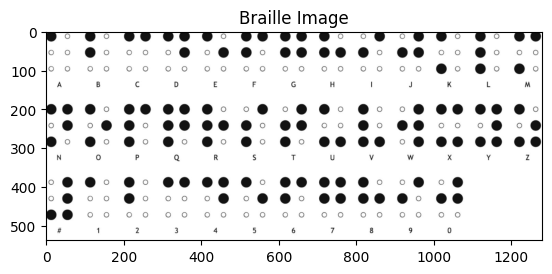

In [226]:
import cv2
import numpy as np
import imutils
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
from gtts import gTTS
import os


# Load the image
image = cv2.imread('image.jpg',cv2.IMREAD_GRAYSCALE)  # Replace with the path to your image
# cv2.imshow('Image', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# image_float = image.astype(float)
plt.imshow(image, cmap='gray')
plt.title('Braille Image')
plt.show()


In [227]:
blurred=cv2.GaussianBlur(image,(15,15),0)
edged=cv2.Canny(blurred,50,200,255)
thresh_inv=cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
ctrs=cv2.findContours(thresh_inv.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
ctrs=imutils.grab_contours(ctrs)

for c in ctrs:
    cv2.drawContours(thresh_inv, [c], -1, (0, 255, 0), 3)


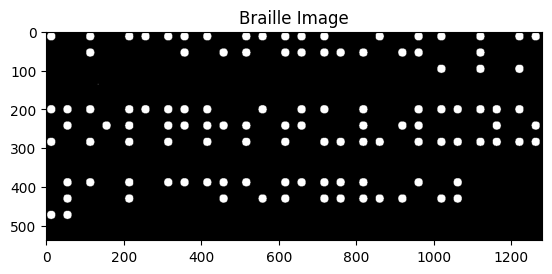

In [228]:
plt.imshow(thresh_inv, cmap='gray')
plt.title('Braille Image')
plt.show()


In [229]:
hist=cv2.reduce(thresh_inv.T,1,cv2.REDUCE_AVG).reshape(-1)

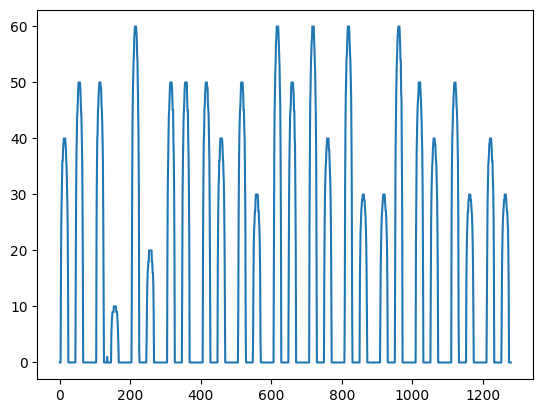

In [230]:
plt.plot(hist)

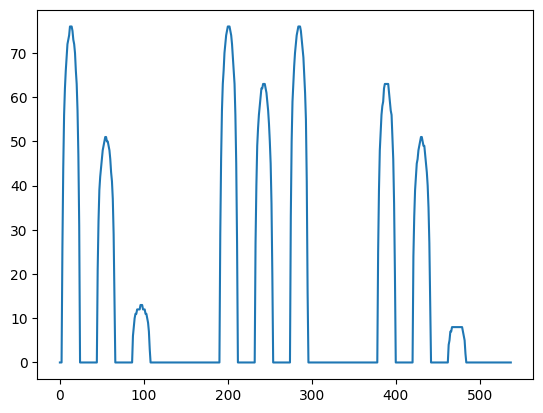

In [231]:
hist2=cv2.reduce(thresh_inv,1,cv2.REDUCE_AVG).reshape(-1)
plt.plot(hist2)

In [232]:
def NumMax(hist):
    local_maxima_count = 0

    for i in range(1, len(hist) - 1):
        if hist[i] > hist[i - 1] and hist[i] > hist[i + 1]:
            local_maxima_count += 1

    # Print the number of local maxima
    print("Number of local maxima:", local_maxima_count)
    return local_maxima_count

In [233]:
rows=NumMax(hist2)
rows=rows/3

print(rows)

Number of local maxima: 0
0.0


In [234]:
def func(hist):
    data = []
    start_idx = None
    current_count = None

    for idx, value in enumerate(hist):
        if start_idx is None:
            # Start of a connected component
            start_idx = idx
            current_count = value
        elif value != current_count:
            # End of a connected component
            end_idx = idx - 1
            # Ensure start and end are not the same, vary by 1
            if start_idx != end_idx:
                pixel_value = hist[start_idx]
                count = end_idx - start_idx
                data.append([pixel_value, count, start_idx, end_idx])
            start_idx = idx
            current_count = value

    # Handling the last connected component
    if start_idx is not None:
        end_idx = len(hist) - 1
        # Ensure start and end are not the same, vary by 1
        if start_idx != end_idx:
            pixel_value = hist[start_idx]
            count = end_idx - start_idx
            data.append([pixel_value, count, start_idx, end_idx])

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data, columns=['pixel_value', 'count', 'start', 'end'])
    return df
    # Print the DataFrame
    # print(df)


In [235]:
df=func(hist)
df2=func(hist2)

In [236]:
sorted_df = df.sort_values(by='count', ascending=False)
print(sorted_df.head())

    pixel_value  count  start   end
26            0     37    368   405
5             0     37     66   103
66            0     37   1073  1110
44            0     37    670   707
20            0     37    267   304


In [237]:
sorted_df2 = df2.sort_values(by='count', ascending=False)
print(sorted_df2.head())

    pixel_value  count  start  end
11            0     82    108  190
18            0     82    296  378
26            0     53    484  537
23            0     20    442  462
20            0     20    400  420


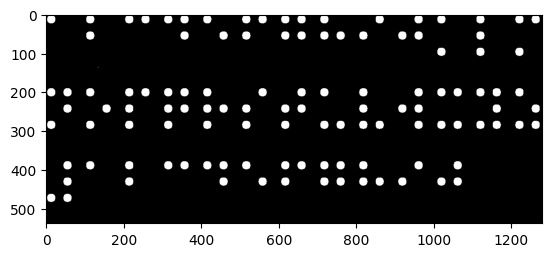

In [238]:
digitCnts = []
for c in ctrs:
    cv2.drawContours(thresh_inv, [c], -1, (0, 255, 0), 3)  # Note the change here, specifying [c] as a list
plt.figure()
plt.imshow(thresh_inv, cmap="gray")


In [239]:
from collections import Counter

# Assuming ctrs is a list of contours
# You might need to replace this line with your actual code to find contours
# Example: _, ctrs, _ = cv2.findContours(thresh_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boundingBoxes = [list(cv2.boundingRect(c)) for c in ctrs]

# Now, boundingBoxes is a list of rectangles in the format (x, y, width, height)

# Convert the list to a tuple to make it hashable
widths = tuple(i[2] for i in boundingBoxes)

# Count the occurrences of widths using Counter
c = Counter(widths)

# Find the most common width
mode = c.most_common(1)[0][0]

# If the mode is greater than 1, use it as the diameter
if mode > 1:
    diam = mode
else:
    # If the mode is 1, use the second most common width as the diameter
    diam = c.most_common(2)[1][0]


In [240]:
print("Diameter of the Braille dot is {}".format(diam))

Diameter of the Braille dot is 27


In [241]:
df_space=deepcopy(df.loc[(df["pixel_value"]==0) & (df["count"]>1.25*diam)])

In [242]:
df_space

,pixel_value,count,start,end
5,0,37,66,103
13,0,36,167,203
20,0,37,267,304
26,0,37,368,405
32,0,36,469,505
39,0,36,570,606
44,0,37,670,707
49,0,36,771,807
55,0,36,872,908
61,0,37,972,1009


In [243]:
rows_space=deepcopy(df2.loc[(df2["pixel_value"]==0) & (df2["count"]>1.25*diam)])

In [244]:
rows_space

,pixel_value,count,start,end
11,0,82,108,190
18,0,82,296,378
26,0,53,484,537


In [245]:
row_start_end = [tuple(x) for x in rows_space[["start","end"]].to_records(index=False)]
row_start = [i[0] for i in row_start_end]
row_end = [i[1] for i in row_start_end]

In [246]:
row_start_end

[(108, 190), (296, 378), (484, 537)]

In [247]:
space_start_end=[tuple(x) for x in df_space[["start","end"]].to_records(index=False)]

In [248]:
space_start_end

[(66, 103),
 (167, 203),
 (267, 304),
 (368, 405),
 (469, 505),
 (570, 606),
 (670, 707),
 (771, 807),
 (872, 908),
 (972, 1009),
 (1073, 1110),
 (1174, 1210)]

In [249]:
starts=[i[0] for i in space_start_end]
ends=[i[1] for i in space_start_end]

In [250]:
def generate_start_end_text_ranges(starts, ends,image):
    text_ranges = []

    if starts[0] != 0:
    # Add the first range (from 0 to the first start)
        text_ranges.append((0, starts[0]))

    # Add the ranges between ends and starts
    for i in range(len(ends) - 1):
        text_ranges.append((ends[i], starts[i + 1]))



    # Add the last range (from the last end to the end of the document)
    if (image.shape[-1] - ends[-1]) != 1:
        text_ranges.append((ends[-1], image.shape[1]))

    # threshold = 0.1

    # if len(text_ranges) > 1:
    #     avg_range = sum(end - start for start, end in text_ranges[:-1]) / (len(text_ranges) - 1)
    #     last_range = ends[-1] - starts[-1]
    #     if avg_range * (1 - threshold) <= last_range <= avg_range * (1 + threshold):
    #     # Merge the last range with the previous range
    #         text_ranges[-1] = (text_ranges[-1][0], image.shape[1])


    return text_ranges


In [251]:
text_region_start_end=generate_start_end_text_ranges(starts,ends,image)
if len(space_start_end)==1:
    if ((ends[-1],image.shape[1]) not in text_region_start_end):
        text_region_start_end.append((space_start_end[0][1],thresh_inv.shape[1]))
if not text_region_start_end:
    text_region_start_end.append((0,thresh_inv.shape[1]))

In [252]:
row_text_region_start_end=generate_start_end_text_ranges(row_start,row_end,image.T)
if len(row_start_end)==1:
    if ((row_start_end[0][1],thresh_inv.T.shape[1]) not in row_text_region_start_end):
        row_text_region_start_end.append((row_start_end[0][1],thresh_inv.T.shape[1]))
if not row_text_region_start_end:
    row_text_region_start_end.append((0,thresh_inv.T.shape[1]))

In [253]:
text_region_start_end

[(0, 66),
 (103, 167),
 (203, 267),
 (304, 368),
 (405, 469),
 (505, 570),
 (606, 670),
 (707, 771),
 (807, 872),
 (908, 972),
 (1009, 1073),
 (1110, 1174),
 (1210, 1280)]

In [254]:
row_text_region_start_end

[(0, 108), (190, 296), (378, 484)]

In [255]:
# from tensorflow import keras

# model = keras.models.load_model('C:/Vishnu/semester Files/5th_semester/Computer Vision/project/model')

# with open('C:/Vishnu/semester Files/5th_semester/Computer Vision/project/model/class_names.txt', 'r') as f:
#     class_names = [line.strip() for line in f]


In [256]:

def count_black_pixels(image):
    # Convert the image to grayscal

    # if len(image.shape) == 3:
    #     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # else:
    #     gray_image = image

    # Count the number of black pixels (pixel value = 0)
    TotalNumberOfPixels = image.shape[0] * image.shape[1]
    black_pixel_count = TotalNumberOfPixels -  cv2.countNonZero(image)

    return black_pixel_count

def check_black_pixel_percentage(image, threshold_percentage=0):

    arr = np.zeros(6)
    # Get the height and width of the image
    height, width= image.shape

    # Divide the image into 6 equal halves
    half_width = width // 2
    half_height = height // 3

    # Calculate the black pixel count and total pixel count for each half
    for i in range(2):
        for j in range(3):
            x_start = i * half_width
            y_start = j * half_height
            x_end = (i + 1) * half_width
            y_end = (j + 1) * half_height

            # Extract the region
            region = image[y_start:y_end, x_start:x_end]

            # Count the black pixels in the region
            black_pixel_count = count_black_pixels(region)

            # Calculate the total pixel count in the region
            total_pixel_count = half_width * half_height

            # Calculate the percentage of black pixels
            black_pixel_percentage = (black_pixel_count / total_pixel_count) * 100

            # Check if the black pixel percentage is greater than the threshold
            if black_pixel_percentage > threshold_percentage:
                arr[2*j + i] = 1
                # print(f"Region ({i + 1}, {j + 1}): Black Pixel Percentage = {black_pixel_percentage}% (Greater than {threshold_percentage}%)")

    return arr

# Example usage



In [257]:
def braille_mapping(braille_input):
    # Define the Braille cell mapping
    braille_map = {
        (1, 0, 0, 0, 0, 0): 'a',
        (1, 0, 1, 0, 0, 0): 'b',
        (1, 1, 0, 0, 0, 0): 'c',
        (1, 1, 0, 1, 0, 0): 'd',
        (1, 0, 0, 1, 0, 0): 'e',
        (1, 1, 1, 0, 0, 0): 'f',
        (1, 1, 1, 1, 0, 0): 'g',
        (1, 0, 1, 1, 0, 0): 'h',
        (0, 1, 1, 0, 0, 0): 'i',
        (0, 1, 1, 1, 0, 0): 'j',
        (1, 0, 0, 0, 1, 0): 'k',
        (1, 0, 1, 0, 1, 0): 'l',
        (1, 1, 0, 0, 1, 0): 'm',
        (1, 1, 0, 1, 1, 0): 'n',
        (1, 0, 0, 1, 1, 0): 'o',
        (1, 1, 1, 0, 1, 0): 'p',
        (1, 1, 1, 1, 1, 0): 'q',
        (1, 0, 1, 1, 1, 0): 'r',
        (0, 1, 1, 0, 1, 0): 's',
        (0, 1, 1, 1, 1, 0): 't',
        (1, 0, 0, 0, 1, 1): 'u',
        (1, 0, 1, 0, 1, 1): 'v',
        (0, 1, 1, 1, 0, 1): 'w',
        (1, 1, 0, 0, 1, 1): 'x',
        (1, 1, 0, 1, 1, 1): 'y',
        (1, 0, 0, 1, 1, 1): 'z',
    }

    # Translate the input to Braille character
    if tuple(braille_input) in braille_map:
        return braille_map[tuple(braille_input)]
    else:
        return "!!!" # Handle undefined input


[1. 0. 0. 0. 0. 0.]


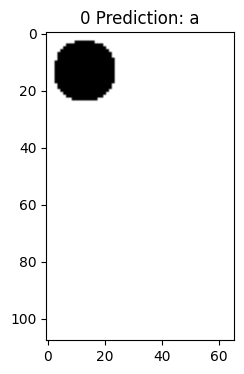

[1. 0. 1. 0. 0. 0.]


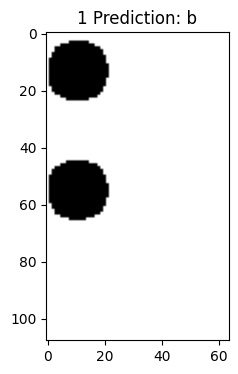

[1. 1. 0. 0. 0. 0.]


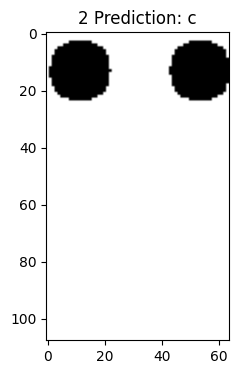

[1. 1. 0. 1. 0. 0.]


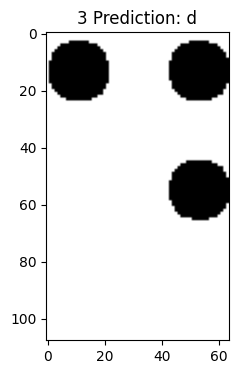

[1. 0. 0. 1. 0. 0.]


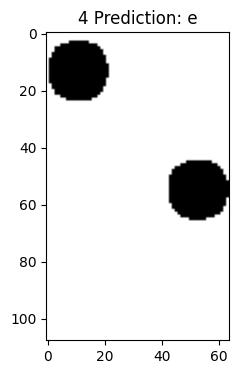

[1. 1. 1. 0. 0. 0.]


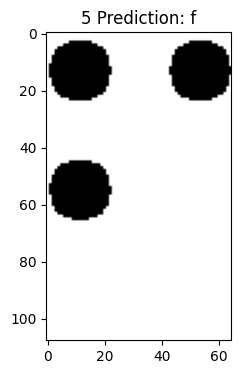

[1. 1. 1. 1. 0. 0.]


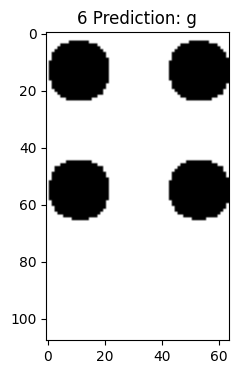

[1. 0. 1. 1. 0. 0.]


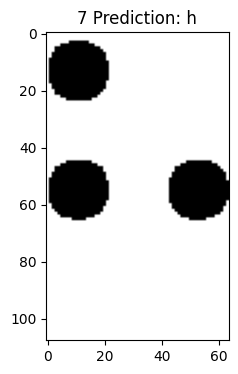

[0. 1. 1. 0. 0. 0.]


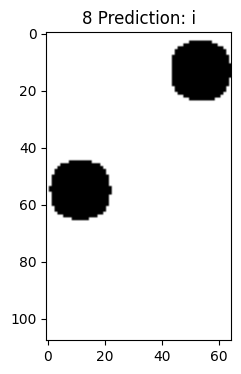

[0. 1. 1. 1. 0. 0.]


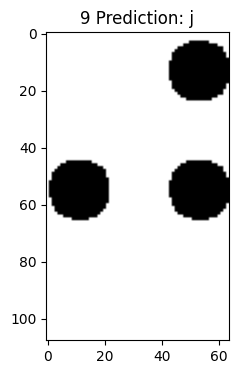

[1. 0. 0. 0. 1. 0.]


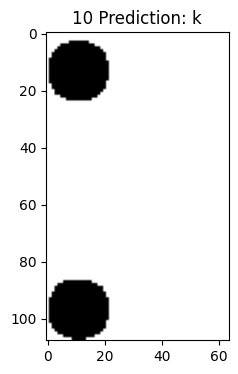

[1. 0. 1. 0. 1. 0.]


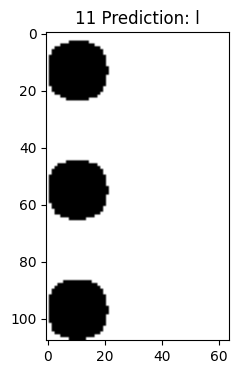

[1. 1. 0. 0. 1. 0.]


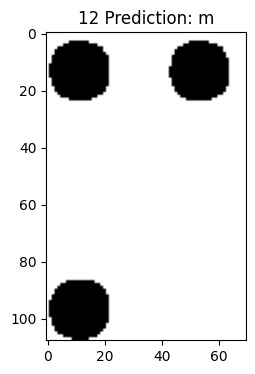

[1. 1. 0. 1. 1. 0.]


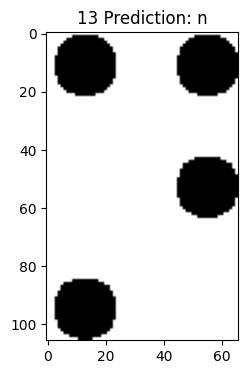

[1. 0. 0. 1. 1. 0.]


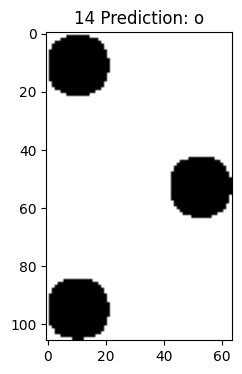

[1. 1. 1. 0. 1. 0.]


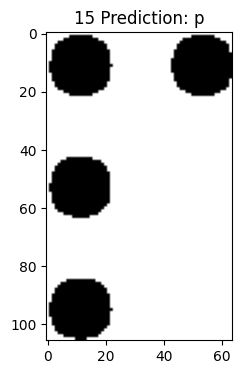

[1. 1. 1. 1. 1. 0.]


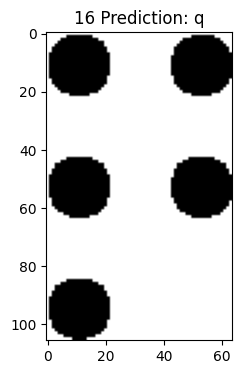

[1. 0. 1. 1. 1. 0.]


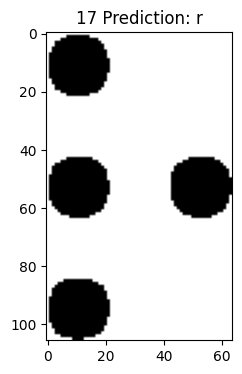

[0. 1. 1. 0. 1. 0.]


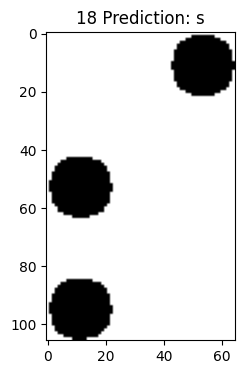

[0. 1. 1. 1. 1. 0.]


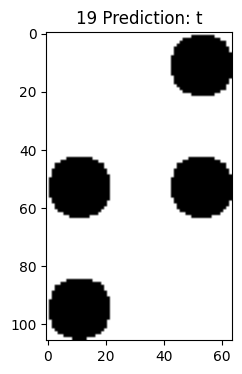

[1. 0. 0. 0. 1. 1.]


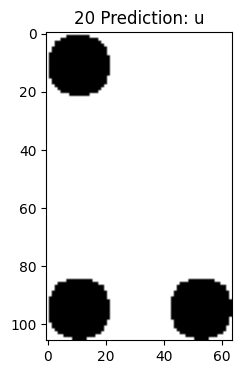

[1. 0. 1. 0. 1. 1.]


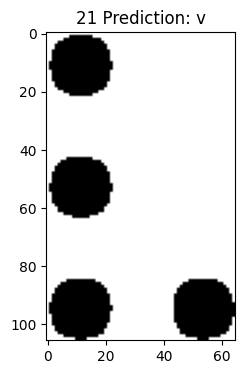

[0. 1. 1. 1. 0. 1.]


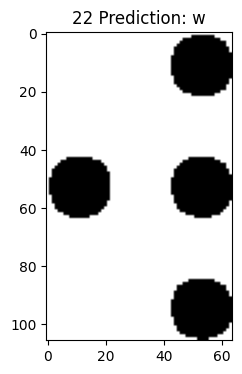

[1. 1. 0. 0. 1. 1.]


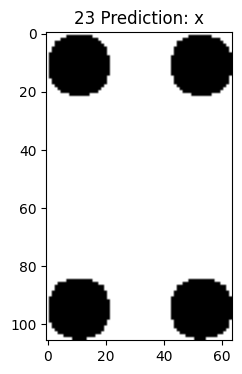

[1. 1. 0. 1. 1. 1.]


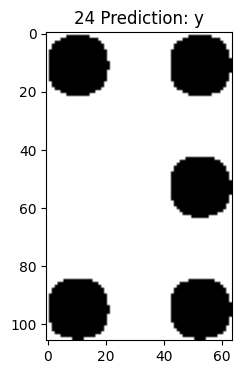

[1. 0. 0. 1. 1. 1.]


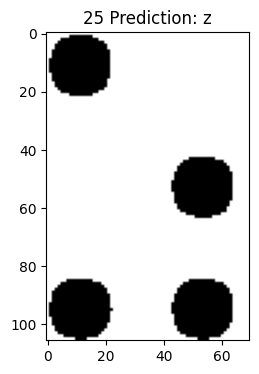

[0. 1. 0. 1. 1. 1.]


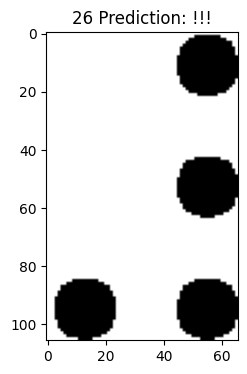

[1. 0. 0. 0. 0. 0.]


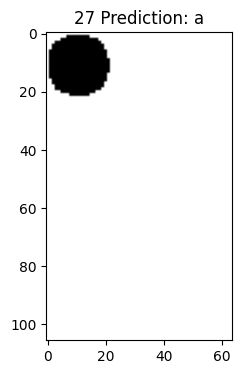

[1. 0. 1. 0. 0. 0.]


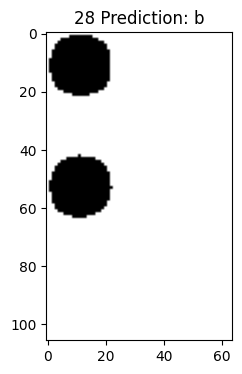

[1. 1. 0. 0. 0. 0.]


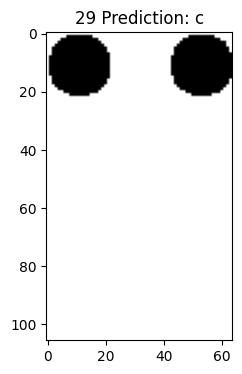

[1. 1. 0. 1. 0. 0.]


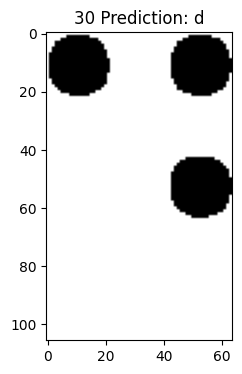

[1. 0. 0. 1. 0. 0.]


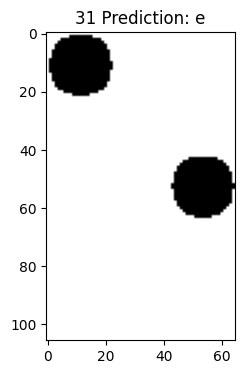

[1. 1. 1. 0. 0. 0.]


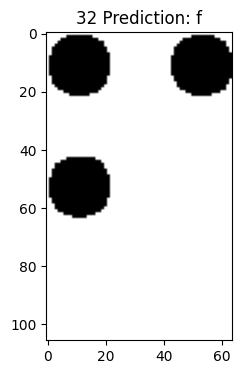

[1. 1. 1. 1. 0. 0.]


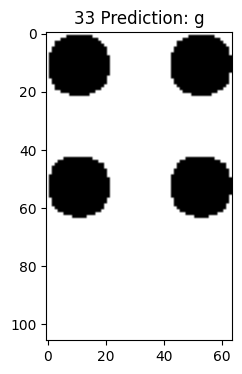

[1. 0. 1. 1. 0. 0.]


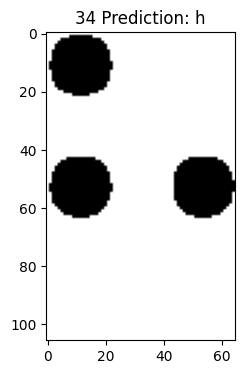

[0. 1. 1. 0. 0. 0.]


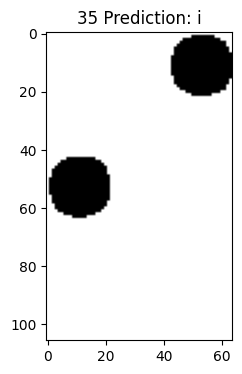

[0. 1. 1. 1. 0. 0.]


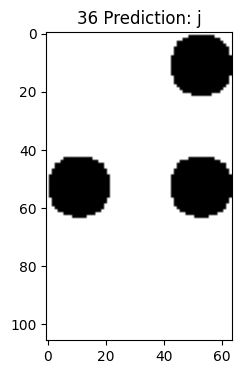

[0. 0. 0. 0. 0. 0.]


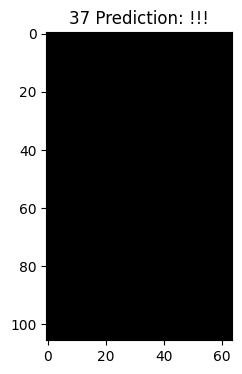

[0. 0. 0. 0. 0. 0.]


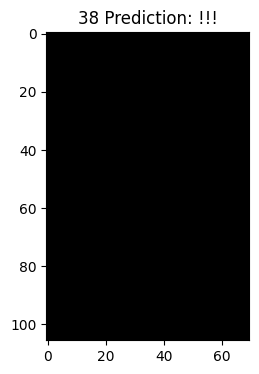

In [258]:
import os

# path = "output_images"
# if not os.path.exists(path):
#     # If not, create it
#     os.makedirs(path)

final_translation = []

for j in range(len(row_text_region_start_end)):
    for i in range(len(text_region_start_end)):
        new_img = cv2.bitwise_not(thresh_inv)
        predict_img = np.array(new_img[row_text_region_start_end[j][0]:row_text_region_start_end[j][1], text_region_start_end[i][0]:text_region_start_end[i][1]])

        arr = check_black_pixel_percentage(predict_img)
        print(arr)
        letter = braille_mapping(arr)
        final_translation.append(arr)
        # final_translation.append(tuple(letter))
        # current_shape = predict_img.shape
        # print(current_shape)
        # new_size = (28, 28)
        # resized_img = cv2.resize(predict_img, (new_size[0], new_size[1]), interpolation=cv2.INTER_AREA)
        # aspect_ratio = current_shape[1] / current_shape[0]
        # new_width = int(min(new_size[0], new_size[1] * aspect_ratio))
        # new_height = int(min(new_size[1], new_size[0] / aspect_ratio))

        # print(new_width,new_height)
        # Resize the image using cv2.resize

        # print(np.shape(resized_img))

        # # Create a new blank image with the target size
        # target_img = np.ones((new_size[0], new_size[1]), dtype=np.uint8) * 255  # White background

        # # Calculate the position to paste the resized image in the center
        # paste_position = ((new_size[0] - new_width) // 2, (new_size[1] - new_height) // 2)

        # # Determine the valid region for pasting
        # paste_rows = slice(max(0, paste_position[0]), min(new_size[0], paste_position[0] + new_height))
        # paste_cols = slice(max(0, paste_position[1]), min(new_size[1], paste_position[1] + new_width))

        # print(paste_cols,paste_rows)

        # # Paste the resized image onto the blank image
        # target_img[paste_rows,paste_cols] = resized_img[:min(new_height, resized_img.shape[0]), :min(new_width, resized_img.shape[1])]

        # print(np.shape(target_img))

        # reshaped_input = resized_img.reshape(-1, 28, 28, 1)

        # expanded_input = np.tile(reshaped_input, (1, 1, 1, 3))

        # predicted_labels = np.argmax(model.predict_generator(expanded_input),axis=1)
        # predicted_class_names = [class_names[label] for label in predicted_labels]

        # os.chdir(path)
        # filename = str(i)+'_'+str(j)+'.jpg'
        # cv2.imwrite(filename,predict_img)
        plt.figure(figsize=(4, 4))
        plt.imshow(predict_img, cmap="gray")
        # plt.title({j * len(text_region_start_end) + i})
        plt.title(f"{j * len(text_region_start_end) + i} Prediction: {letter}")
        plt.show()

In [259]:
final_translation

[array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 1., 0., 0., 0.]),
 array([1., 1., 0., 0., 0., 0.]),
 array([1., 1., 0., 1., 0., 0.]),
 array([1., 0., 0., 1., 0., 0.]),
 array([1., 1., 1., 0., 0., 0.]),
 array([1., 1., 1., 1., 0., 0.]),
 array([1., 0., 1., 1., 0., 0.]),
 array([0., 1., 1., 0., 0., 0.]),
 array([0., 1., 1., 1., 0., 0.]),
 array([1., 0., 0., 0., 1., 0.]),
 array([1., 0., 1., 0., 1., 0.]),
 array([1., 1., 0., 0., 1., 0.]),
 array([1., 1., 0., 1., 1., 0.]),
 array([1., 0., 0., 1., 1., 0.]),
 array([1., 1., 1., 0., 1., 0.]),
 array([1., 1., 1., 1., 1., 0.]),
 array([1., 0., 1., 1., 1., 0.]),
 array([0., 1., 1., 0., 1., 0.]),
 array([0., 1., 1., 1., 1., 0.]),
 array([1., 0., 0., 0., 1., 1.]),
 array([1., 0., 1., 0., 1., 1.]),
 array([0., 1., 1., 1., 0., 1.]),
 array([1., 1., 0., 0., 1., 1.]),
 array([1., 1., 0., 1., 1., 1.]),
 array([1., 0., 0., 1., 1., 1.]),
 array([0., 1., 0., 1., 1., 1.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 1., 0., 0., 0.]),
 array([1., 1.

In [260]:
[sum([int(x) * (2 ** i) for i, x in enumerate(l)]) for l in final_translation]

[1,
 5,
 3,
 11,
 9,
 7,
 15,
 13,
 6,
 14,
 17,
 21,
 19,
 27,
 25,
 23,
 31,
 29,
 22,
 30,
 49,
 53,
 46,
 51,
 59,
 57,
 58,
 1,
 5,
 3,
 11,
 9,
 7,
 15,
 13,
 6,
 14,
 0,
 0]

In [261]:
ref ={'A':1,'B':5,'C':3,'D':11,'E':9,'F':7,'G':15,'H':13,'I':6,'J':14,'K':17,'L':21,'M':19,'N':27,'O':25,'P':23,'Q':31,'R':29,'S':22,'T':30,'U':49,'V':53,'W':46,'X':51,'Y':59,'Z':57}

vals = [sum([int(x) * (2 ** i) for i, x in enumerate(l)]) for l in final_translation]
vals = vals[:-13]
word =[]
for val in vals:
  letter = list(filter(lambda x: ref[x] == val, ref))[0]
  word.append(letter)

In [264]:
def text_to_speech(text, language='en', output_file='output.mp3'):
    tts = gTTS(text=text, lang=language, slow=False)
    tts.save(output_file)
    play_audio(output_file)

def play_audio(audio_file):
    os.system(f'start {audio_file}')
s = ''.join(word)
print(s)
text_to_speech(s)

ABCDEFGHIJKLMNOPQRSTUVWXYZ
